# Music Genre Classification - Audio Data Classification Modeling (Approach : CNN)

### Imports

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa
import pandas as pd

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load Data
- Load in the MFCCs and genre classifications.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
Root = "/content/drive/MyDrive/Data"
os.chdir(Root)

Mounted at /content/drive


In [ ]:
audio_data_path = "/content/drive/MyDrive/Data/genres_original"
data = pd.read_csv("/content/drive/MyDrive/Data/features_30_sec.csv")
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


## Modeling
- Two types of models were tested
    - Dense Neural Network (DNN)
    - Convolutional Neural Network (CNN)
- For audio and image classification, CNNs typically outperform DNNs. Our testing confirmed this, so we worked with the CNN to improve its performance through parameter tuning and regularization techniques.
- Additionally, data needs to be in the correct "shape" in order to input into certain models.
    - DNN: (n, n)
    - CNN: (n, n, 1)
- Data is also split into 3 sets
    - Training set: For the model to train on
    - Validation set: For the model to compare against while training
    - Test set: A set unsees by the model until the end for final testing

In [ ]:
# Define X and y
# Extract MFCC features (mean and variance for each coefficient)
# The 'features_30_sec.csv' contains statistical summaries of MFCCs (e.g., mfcc1_mean, mfcc1_var).
# We collect all columns starting with 'mfcc' as our features for X.
mfcc_cols = [col for col in data.columns if 'mfcc' in col]
X = np.array(data[mfcc_cols])

# Encode the 'label' column to numerical format for y
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(data["label"])

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (1000, 40)
Shape of y: (1000,)


In [ ]:
# Define X and y
# Extract MFCC features (mean and variance for each coefficient)
mfcc_cols = [col for col in data.columns if 'mfcc' in col]
X = np.array(data[mfcc_cols])

#  APPLY MIN-MAX SCALING
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Before scaling:", X[:2])
print("After scaling:", X_scaled[:2])

# Encode the 'label' column to numerical format for y
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(data["label"])

print(f"Shape of X_scaled: {X_scaled.shape}")
print(f"Shape of y: {y.shape}")


Before scaling: [[-1.13570648e+02  2.56420752e+03  1.21571793e+02  2.95913818e+02
  -1.91681423e+01  2.35574432e+02  4.23664207e+01  1.51106873e+02
  -6.36466408e+00  1.67934799e+02  1.86234989e+01  8.91808395e+01
  -1.37048912e+01  6.76604919e+01  1.53431501e+01  6.89325790e+01
  -1.22741098e+01  8.22042007e+01  1.09765720e+01  6.33863106e+01
  -8.32657337e+00  6.17730942e+01  8.80379200e+00  5.12441254e+01
  -3.67230010e+00  4.12174149e+01  5.74799490e+00  4.05544777e+01
  -5.16288185e+00  4.97754211e+01  7.52740204e-01  5.24209099e+01
  -1.69021463e+00  3.65240707e+01 -4.08979177e-01  4.15971031e+01
  -2.30352259e+00  5.50629234e+01  1.22129071e+00  4.69360352e+01]
 [-2.07501694e+02  7.76455518e+03  1.23991264e+02  5.60259949e+02
   8.95512676e+00  5.72810913e+02  3.58776474e+01  2.64506104e+02
   2.90731978e+00  2.79932922e+02  2.15104656e+01  1.56477097e+02
  -8.56043625e+00  2.00849182e+02  2.33706856e+01  1.42555954e+02
  -1.00996609e+01  1.66108521e+02  1.19004974e+01  1.043586

In [ ]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (490, 40), y training data shape: (490,)
X validation data shape: (210, 40), y validation data shape: (210,)


In [ ]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs

    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)

    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")

    plt.show()

### Dense Neural Network (DNN)
- A Dense Neural Network consists of multiple dense layers ordered sequentially one after the other.
- An 'l2' regularization penalty was leveraged to help mitigate overfitting.
- Dropout layers were included to help mitigate overfitting.
- Dense neural networks are useful for some tasks, but often do not perform as well on image and audio data.

In [ ]:
# Dense Neural Network

# Instantiate sequential model
model_dnn = Sequential()

# Flatten to dense
model_dnn.add(Flatten(input_shape=(X.shape[1:3])))

# Create Dense Layers
model_dnn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Review model structure
model_dnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,418 (661.79 KB)

 Trainable params: 169,418 (661.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile
model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
# Train the model
hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.1022 - loss: 2.8241 - val_acc: 0.1095 - val_loss: 2.8083
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.0860 - loss: 2.8298 - val_acc: 0.1048 - val_loss: 2.7957
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.1411 - loss: 2.8123 - val_acc: 0.0952 - val_loss: 2.7833
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.1118 - loss: 2.7915 - val_acc: 0.1190 - val_loss: 2.7712
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.1224 - loss: 2.7835 - val_acc: 0.1143 - val_loss: 2.7593
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.1433 - loss: 2.7635 - val_acc: 0.1619 - val_loss: 2.7474
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.1382 - loss: 2.7562 - val_acc: 0.1810 - val_loss: 2.7356
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.1465 - loss: 2.7525 - val_acc: 0.2190 - val_loss: 2.7233
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.1412 - loss: 

In [ ]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test) #check for test accuracy
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.6123 - loss: 1.3857 
Test Loss: 1.4054906368255615
Test Accuracy: 0.596666693687439


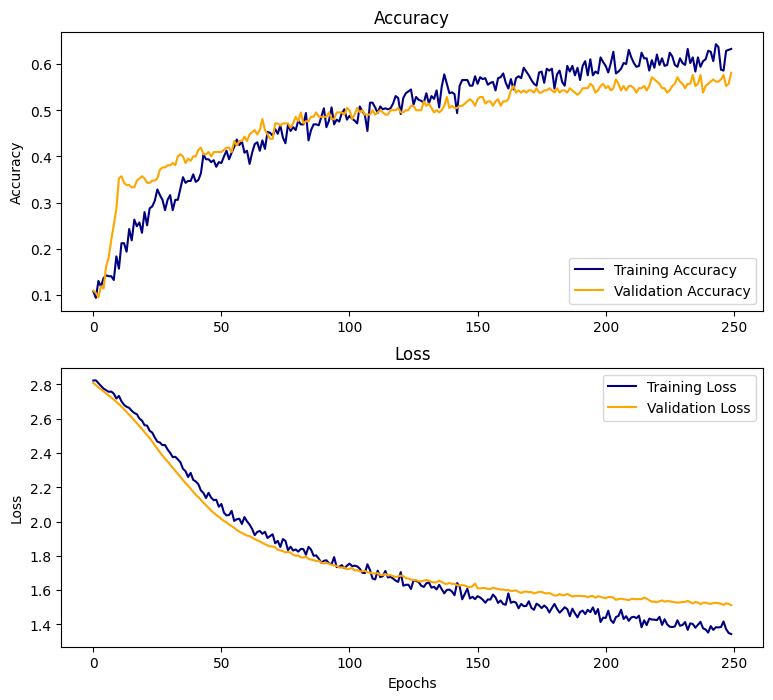

In [ ]:
plot_history(hist_dnn)

### Convolutional Neural Network (Without Regularization)
- A Convolutional Neural Network (CNN) consists of a combination of convolution layers and dense layers.
- Convolution layers first begin to identify features within the data, similar to edge detection in image data.
- The the data is flattened out to run through dense layers to classify the data.
- A base CNN was tested without regulatization methods to establish a base performance before iterating through tuning parameters.

In [ ]:
# Add additional dimension for CNN (requirement for keras)
X_train_cnn = X_train[..., np.newaxis, np.newaxis]
X_val_cnn = X_val[..., np.newaxis, np.newaxis]
X_test_cnn = X_test[..., np.newaxis, np.newaxis]

input_shape = X_train_cnn.shape[1:]
print(f"X training data shape for CNN: {X_train_cnn.shape}") # shape = (# samples, time-bins (x), num MFCCs (y), "channel" (like an image))
print(f"Input shape for CNN layer: {input_shape}")

X training data shape for CNN: (490, 40, 1, 1)
Input shape for CNN layer: (40, 1, 1)


In [ ]:
# Convolutional Neural Network - Original

# Instantiate sequential model
model_cnn1 = Sequential()

# first convolution block
model_cnn1.add(Conv2D(32, (3, 1), activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn1.add(MaxPooling2D((3, 1), strides=(2, 1), padding='same')) # MaxPool the results

# second conv block
model_cnn1.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn1.add(MaxPooling2D((3, 1), strides=(2, 1), padding='same'))

# third conv block
model_cnn1.add(Conv2D(64, (2, 1), activation='relu'))
model_cnn1.add(MaxPooling2D((2, 1), strides=(2, 1), padding='same'))

# Flatten output to send through dense layers
model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

# output to 10 classes for predictions
model_cnn1.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_cnn1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 9, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 1, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,690 (123.79 KB)

 Trainable params: 31,690 (123.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
%%time
# Train the model
hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - acc: 0.1090 - loss: 2.3028 - val_acc: 0.1000 - val_loss: 2.3043
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.0906 - loss: 2.3079 - val_acc: 0.1000 - val_loss: 2.3028
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.1074 - loss: 2.3009 - val_acc: 0.1000 - val_loss: 2.3017
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.1111 - loss: 2.3002 - val_acc: 0.1000 - val_loss: 2.3006
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.0903 - loss: 2.3015 - val_acc: 0.1000 - val_loss: 2.2993
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.1231 - loss: 2.2950 - val_acc: 0.1238 - val_loss: 2.2979
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.1725 - loss: 2.2923 - val_acc: 0.1619 - val_loss: 2.2966
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.1665 - loss: 2.2951 - val_acc: 0.1714 - val_loss: 2.2952
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.1642 - loss: 

In [ ]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.4915 - loss: 1.4499 
Test Loss: 1.467926263809204
Test Accuracy: 0.47333332896232605


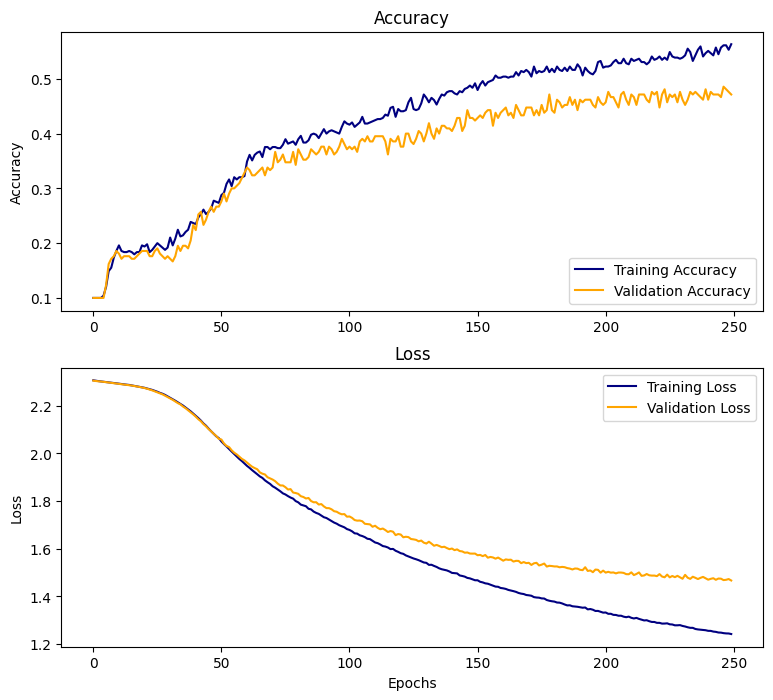

In [ ]:
plot_history(hist_cnn1)

### Convolutional Neural Network (With Regularization)
- A Convolutional Neural Network (CNN) consists of a combination of convolution layers and dense layers.
- Convolution layers first begin to identify features within the data, similar to edge detection in image data.
- The the data is flattened out to run through dense layers to classify the data.
- The CNN below went through many iterations to tune regularization parameters. We included:
    - Dropout: Drops some nodes through each epoch to force all nodes to learn all features of the model. This helps reduce overfitting of the model.
    - Early Stopping: This stops the model once it has reached a certain threshold of no longer improving. This also helps reduce overfitting.
    - Regularization penalties (such as 'l2') were *not* leveraged for the CNN, as they do not improve the performance of the model.

In [ ]:
# Convolutional Neural Network - BEST

# Instantiate sequential model
model_cnn2 = Sequential()

# First conv block
model_cnn2.add(Conv2D(32, (3, 1), activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D((3, 1), strides=(2, 1), padding='same')) # MaxPool the results
model_cnn2.add(Dropout(0.2))

# second conv block
model_cnn2.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D((3, 1), strides=(2, 1), padding='same'))
model_cnn2.add(Dropout(0.1))

# third conv block
model_cnn2.add(Conv2D(64, (2, 1), activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D((2, 1), strides=(2, 1), padding='same'))
model_cnn2.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn2.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [ ]:
model_cnn2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 38, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 17, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 9, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 9, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 1, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 4, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,418 (193.04 KB)

 Trainable params: 49,098 (191.79 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
# Create an early stopping callback
es_cnn2 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0)

In [ ]:
%%time
# Train the model
hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - acc: 0.0809 - loss: 3.7580 - val_acc: 0.1238 - val_loss: 2.3015
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.1127 - loss: 3.5339 - val_acc: 0.1000 - val_loss: 2.3017
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - acc: 0.1131 - loss: 3.3137 - val_acc: 0.1000 - val_loss: 2.3083
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.1060 - loss: 3.4045 - val_acc: 0.1000 - val_loss: 2.3146
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.1099 - loss: 3.2686 - val_acc: 0.1000 - val_loss: 2.3220
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.1117 - loss: 3.1784 - val_acc: 0.1000 - val_loss: 2.3307
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.1472 - loss: 3.0408 - val_acc: 0.1000 - val_loss: 2.3410
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.1351 - loss: 3.1911 - val_acc: 0.1000 - val_loss: 2.3512
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.1518 - loss:

In [ ]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5330 - loss: 1.3685 
Test Loss: 1.395179033279419
Test Accuracy: 0.5366666913032532


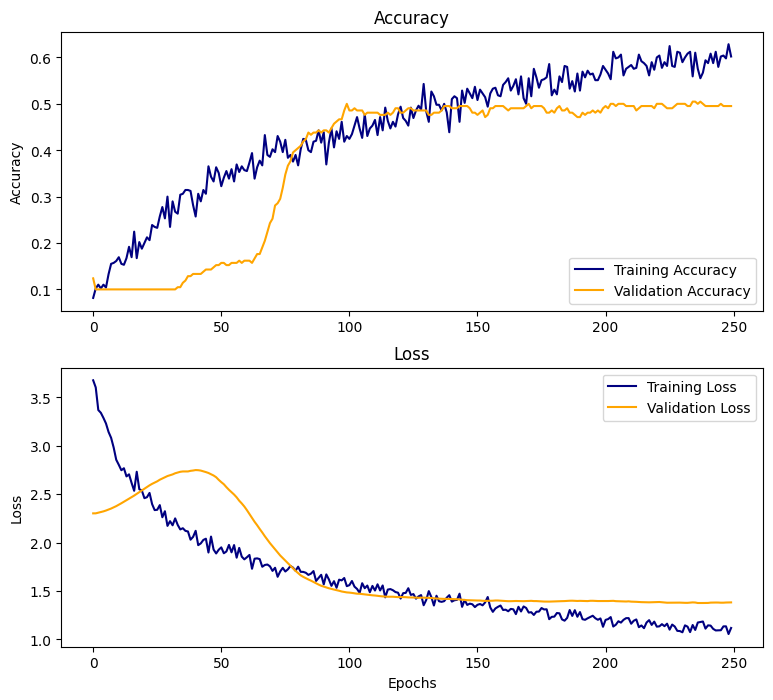

In [ ]:
plot_history(hist_cnn2)

### Convolutional Neural Network (With Regularization and Data Augmentation)
- This model is exactly the same as the previous CNN with regularization techniques implemented, with an addition of a data augmentation technique.
- Because the audio data has essentially been transcoded into something similar to an image, flipping the "image" can effectively add more diverse data for the model to train on. This flipping is analogous to feeding the audio clip through the model in reverse.
- Adding this diversity in data can improve the model without having to truly provide it more data.

In [ ]:

# Instantiate sequential model
model_cnn3 = Sequential()

# first convolution block
model_cnn3.add(Conv2D(32, (3, 1), activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((3, 1), strides=(2, 1), padding='same')) # MaxPool the results
model_cnn3.add(Dropout(0.2))

# second conv block
model_cnn3.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((3, 1), strides=(2, 1), padding='same'))
model_cnn3.add(Dropout(0.1))

#third conv block
model_cnn3.add(Conv2D(64, (2, 1), activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D((2, 1), strides=(2, 1), padding='same'))
model_cnn3.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu'))
model_cnn3.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn3.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [ ]:
model_cnn3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 38, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 17, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 9, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 9, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 1, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 4, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 4, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,418 (193.04 KB)

 Trainable params: 49,098 (191.79 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [ ]:
# Datagen (used for augmentation)
datagen = ImageDataGenerator(vertical_flip=True)

In [ ]:
# Create an early stopping callback
es_cnn3 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0)

In [ ]:
%%time
# Train the model
hist_cnn3 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=400,
    verbose=1
#     callbacks=[es_cnn]
)

Epoch 1/400


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - acc: 0.0928 - loss: 3.7276 - val_acc: 0.1000 - val_loss: 2.3083
Epoch 2/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.1056 - loss: 3.5278 - val_acc: 0.1000 - val_loss: 2.3229
Epoch 3/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.1060 - loss: 3.4976 - val_acc: 0.1000 - val_loss: 2.3467
Epoch 4/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1111 - loss: 3.3356 - val_acc: 0.1000 - val_loss: 2.3772
Epoch 5/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1661 - loss: 3.1321 - val_acc: 0.1000 - val_loss: 2.4138
Epoch 6/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.1140 - loss: 3.2694 - val_acc: 0.1000 - val_loss: 2.4556
Epoch 7/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1129 - loss: 3.1469 - val_acc: 0.1000 - val_loss: 2.4977
Epoch 8/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1125 - loss: 3.0607 - val_acc: 0.1000 - val_loss: 2.5388
Epoch 9/400
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1485 - 

In [ ]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.5323 - loss: 1.3827 
Test Loss: 1.399635910987854
Test Accuracy: 0.5133333206176758


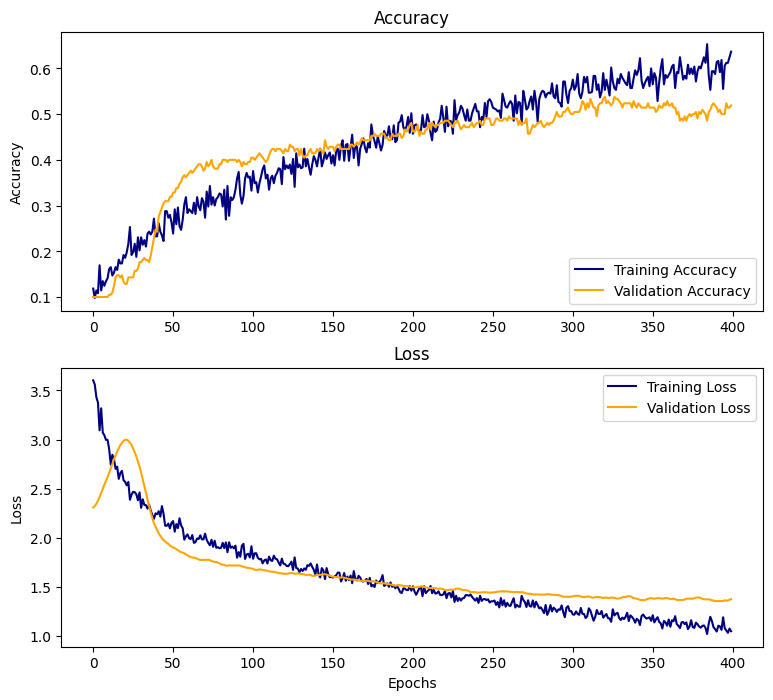

In [ ]:
plot_history(hist_cnn3)

### Save Models
- Save the model to disk to allow for later predictions

In [ ]:
model_dnn.save('../models/model_dnn.h5')
model_cnn1.save('../models/model_cnn1.h5')
model_cnn2.save('../models/model_cnn2.h5')
model_cnn3.save('../models/model_cnn3.h5')

### Make Predictions
- Make predictions on the "test" dataset that the model has not seen yet. This simulates how well the model has been generalized (i.e. can perform on new data).

In [ ]:
def make_prediction(model, X):
    """Makes predictions given a keras model and a set of data.

    Parameters:
        model (keras model): The model to use to make predictions
        X (np.sdarray): Testing data to be fed into the model to make predictions with.

    Returns:
        preds_num (list): List of genre predictions (number format, 0-9)
        preds_name (list): List of genre predictions (str format)
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1) # predicted index
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])

    return preds_num, preds_name

In [ ]:
%%time
# Make predictions - Takes ~10 min to run
preds_num, preds_name = make_prediction(model_cnn3, X_test_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, preds_num)

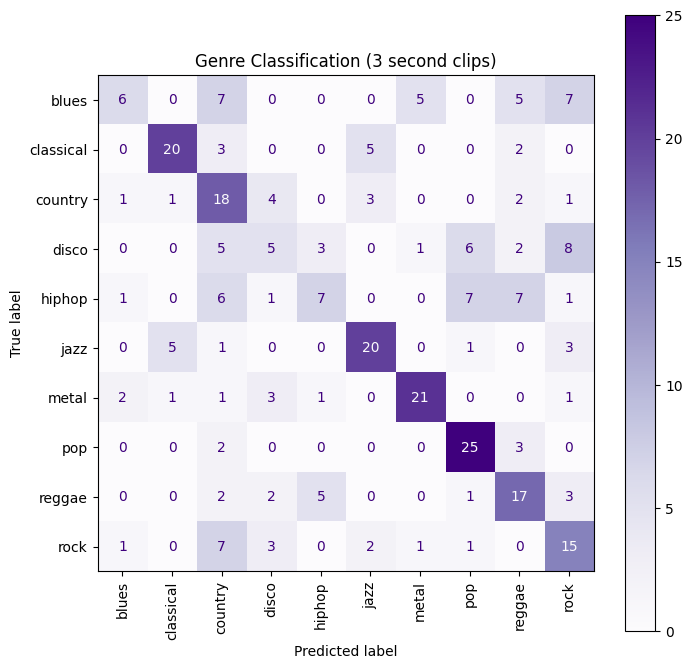

In [ ]:
# Plot confusion matrix for review
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Genre Classification (3 second clips)');

In [ ]:
print(f"DNN Test Accuracy: {acc_dnn}")
print(f"CNN (Without Regularization) Test Accuracy: {acc_cnn1}")
print(f"CNN (With Regularization) Test Accuracy: {acc_cnn2}")
print(f"CNN (With Regularization and Data Augmentation) Test Accuracy: {acc_cnn3}")

DNN Test Accuracy: 0.596666693687439
CNN (Without Regularization) Test Accuracy: 0.47333332896232605
CNN (With Regularization) Test Accuracy: 0.5366666913032532
CNN (With Regularization and Data Augmentation) Test Accuracy: 0.5133333206176758


Since we observed low test accuracy even after using
regularisation and droupout layers , it is evident that cnns perform properly only when the size of the dataset is huge , in other words , cnns are data hungry models.However , we did try to train a denser and more complex models(Below).

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 38, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 17, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 9, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 9, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 1, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 8, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 4, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 4, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 3, 1, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 3, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 2, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 2, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,458 (876.79 KB)

 Trainable params: 223,498 (873.04 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - acc: 0.1248 - loss: 3.6381 - val_acc: 0.1000 - val_loss: 2.3042
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.1595 - loss: 3.4620 - val_acc: 0.1000 - val_loss: 2.3037
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.1359 - loss: 3.3061 - val_acc: 0.1000 - val_loss: 2.3042
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.1507 - loss: 3.1976 - val_acc: 0.1000 - val_loss: 2.3059
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.1767 - loss: 2.7809 - val_acc: 0.1000 - val_loss: 2.3087
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.2131 - loss: 2.7180 - val_acc: 0.1000 - val_loss: 2.3134
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.1844 - loss: 2.5465 - val_acc: 0.1000 - val_loss: 2.3206
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.2088 - loss: 2.7106 - val_acc: 0.1000 - val_loss: 2.3308
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.2326 - loss: 

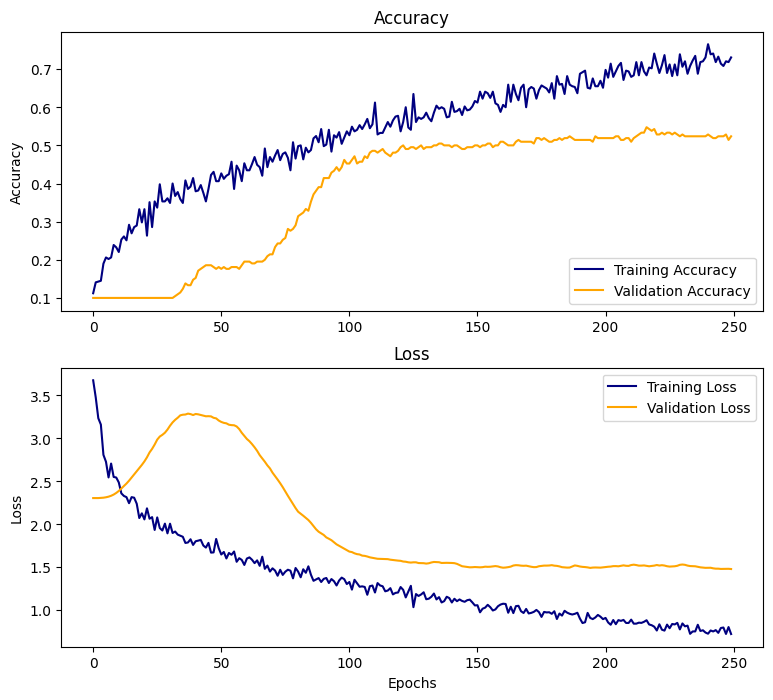

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten,
    BatchNormalization, Dropout, Input
)
from tensorflow.keras.optimizers import Adam


model_cnn_deeper = Sequential()

# First convolution block
model_cnn_deeper.add(Conv2D(
    32, (3, 1), activation='relu', input_shape=input_shape))
model_cnn_deeper.add(BatchNormalization())
model_cnn_deeper.add(MaxPooling2D((3, 1), strides=(2, 1), padding='same'))
model_cnn_deeper.add(Dropout(0.2))

# Second convolution block
model_cnn_deeper.add(Conv2D(64, (3, 1), activation='relu'))
model_cnn_deeper.add(BatchNormalization())
model_cnn_deeper.add(MaxPooling2D((3, 1), strides=(2, 1), padding='same'))
model_cnn_deeper.add(Dropout(0.1))

# Third convolution block
model_cnn_deeper.add(Conv2D(128, (2, 1), activation='relu'))
model_cnn_deeper.add(BatchNormalization())
model_cnn_deeper.add(MaxPooling2D((2, 1), strides=(2, 1), padding='same'))
model_cnn_deeper.add(Dropout(0.1))

# Fourth convolution block
model_cnn_deeper.add(Conv2D(256, (2, 1), activation='relu'))
model_cnn_deeper.add(BatchNormalization())
model_cnn_deeper.add(MaxPooling2D((2, 1), strides=(2, 1), padding='same'))
model_cnn_deeper.add(Dropout(0.1))

# Dense layers
model_cnn_deeper.add(Flatten())
model_cnn_deeper.add(Dense(256, activation='relu'))
model_cnn_deeper.add(Dropout(0.5))

# Output layer
model_cnn_deeper.add(Dense(10, activation='softmax'))


model_cnn_deeper.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)


model_cnn_deeper.summary()



hist_cnn_deeper = model_cnn_deeper.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)


loss_cnn_deeper, acc_cnn_deeper = model_cnn_deeper.evaluate(X_test_cnn, y_test)
print(f"Deeper CNN Test Accuracy: {acc_cnn_deeper}")


plot_history(hist_cnn_deeper)


Since custom architectures seemed to underperform , we tried existing architectures like LeNet(used here).However , we had to modify the architecture somewhat to suit the problem statement.

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 36, 1, 6)       │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 36, 1, 6)       │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 18, 1, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 14, 1, 16)      │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 14, 1, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 120)            │        13,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,194 (98.41 KB)

 Trainable params: 25,150 (98.24 KB)

 Non-trainable params: 44 (176.00 B)

Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - acc: 0.1165 - loss: 3.1099 - val_acc: 0.1381 - val_loss: 2.3020
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.1171 - loss: 3.0074 - val_acc: 0.1048 - val_loss: 2.3010
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.1153 - loss: 3.0061 - val_acc: 0.0667 - val_loss: 2.3010
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.1359 - loss: 2.9321 - val_acc: 0.0905 - val_loss: 2.3013
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.1263 - loss: 2.8936 - val_acc: 0.0952 - val_loss: 2.3002
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.1129 - loss: 2.9205 - val_acc: 0.1095 - val_loss: 2.2995
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1408 - loss: 2.8264 - val_acc: 0.1048 - val_loss: 2.2992
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.1169 - loss: 2.7475 - val_acc: 0.1095 - val_loss: 2.2990
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1241 - loss: 

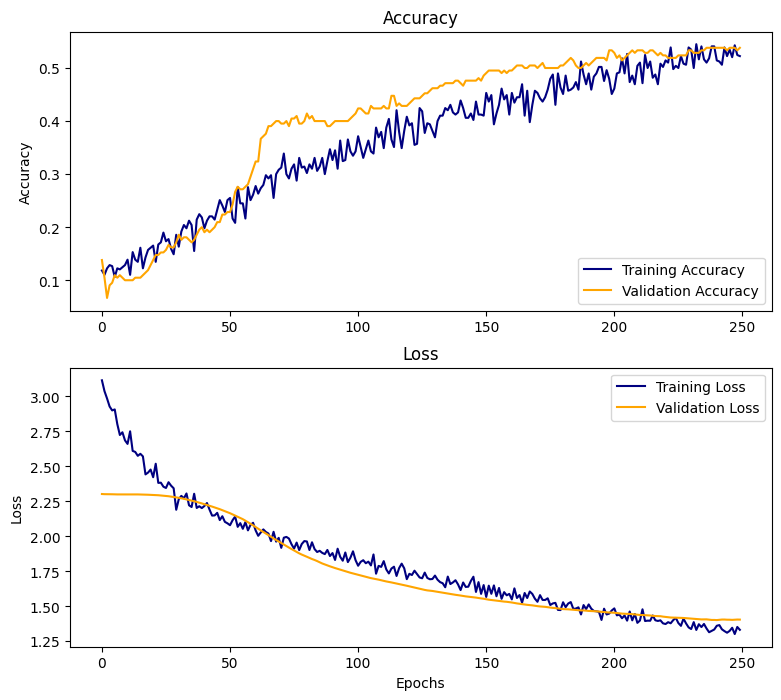

In [ ]:
# LeNet-5 Inspired Architecture (Adapted for MFCCs)

# Instantiate sequential model
model_lenet_like = Sequential()

# First Convolutional Block (inspired by LeNet-5's C1 layer)
# LeNet-5 used 5x5 filters. Adapting to (X,1) input means (5,1) filters.
model_lenet_like.add(Conv2D(filters=6, kernel_size=(5, 1), activation='relu', input_shape=input_shape))
model_lenet_like.add(BatchNormalization())
model_lenet_like.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1))) # S2 layer

# Second Convolutional Block (inspired by LeNet-5's C3 layer)
# LeNet-5 used 16 filters.
model_lenet_like.add(Conv2D(filters=16, kernel_size=(5, 1), activation='relu'))
model_lenet_like.add(BatchNormalization())
model_lenet_like.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1))) # S4 layer

# Flatten output to send through dense layers (F5 layer)
model_lenet_like.add(Flatten())
model_lenet_like.add(Dense(120, activation='relu')) # LeNet-5 had 120 neurons here
model_lenet_like.add(Dropout(0.5)) # Add dropout for regularization

model_lenet_like.add(Dense(84, activation='relu')) # Another dense layer
model_lenet_like.add(Dropout(0.5))

# Output layer
model_lenet_like.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

model_lenet_like.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# Summary
model_lenet_like.summary()

# Training and Evaluation
hist_lenet_like = model_lenet_like.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

loss_lenet_like, acc_lenet_like = model_lenet_like.evaluate(X_test_cnn, y_test)
print(f"LeNet-like CNN Test Accuracy: {acc_lenet_like}")
plot_history(hist_lenet_like)

In [ ]:
print(f"DNN Test Accuracy: {acc_dnn:.4f}")
print(f"CNN (Without Regularization) Test Accuracy: {acc_cnn1:.4f}")
print(f"CNN (With Regularization) Test Accuracy: {acc_cnn2:.4f}")
print(f"CNN (With Regularization and Data Augmentation) Test Accuracy: {acc_cnn3:.4f}")
print(f"Deeper Custom CNN Test Accuracy: {acc_cnn_deeper:.4f}")
print(f"LeNet-like CNN Test Accuracy: {acc_lenet_like:.4f}")

DNN Test Accuracy: 0.5967
CNN (Without Regularization) Test Accuracy: 0.4733
CNN (With Regularization) Test Accuracy: 0.5367
CNN (With Regularization and Data Augmentation) Test Accuracy: 0.5133
Deeper Custom CNN Test Accuracy: 0.4933
LeNet-like CNN Test Accuracy: 0.5033


## Conclusions & Recommendations

### Model Performance Summary
Below are the final performance metrics for all models that were tested.
*NOTE:* All models were overfit, as is common with neural networks. We worked to balance overfitting the model with performance to ensure optimal performance on unseen data.

|**Model**|**Accuracy**|
|---|---|
|**DNN**|0.1|
|**CNN (Without Regularization)**|0.4967|
|**CNN (With Regularization)**|0.5167|
|**CNN (With Regularization and Data Manipulation)**|0.4533|

So far , all cnn models were being trained on top of the exiting csv file , such that each cell was treated like an individual pixel carrying some value.Since it seemed to underperform , we resorted to using actual Mel spectrograms for training our models.

In [ ]:
pip install librosa pandas


In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=9d77f1fed28424217960e6f3e1249abf098f1fc15667dbf888e19a8d63488cd5
  Stored in directory: /root/.cache/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features


Preprocessing :

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
from sklearn.preprocessing import LabelEncoder

#  Initialize empty lists
mel_spectrograms = []
genre_labels_mel = []

#  Define parameters for Mel spectrogram extraction
n_mels = 128
max_pad_len_mel = 172  #  length chosen based on common audio processing practices , (source : ChatGpt)


#  Iterate through each genre directory
for dirpath, dirnames, filenames in os.walk(audio_data_path):
    # Ensure we are in a genre subdirectory (not the root 'genres_original' folder itself)
    if dirpath != audio_data_path:
        genre_label = dirpath.split("/")[-1] # Extract genre name from directory path
        print(f"Processing genre: {genre_label}")

        #  For each audio file in a genre directory
        for f in filenames:
            if f.endswith('.wav'):
                file_path = os.path.join(dirpath, f)

                #  Load the audio file
                try:
                    audio, sr = librosa.load(file_path, sr=None) # sr=None to preserve original sample rate
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                #  Extract Mel spectrograms
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)

                #  Convert the Mel spectrogram from amplitude to decibels
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                # Pad or truncate Mel spectrogram array to consistent number of frames
                if mel_spec_db.shape[1] < max_pad_len_mel:
                    # Pad with zeros if shorter
                    pad_width = max_pad_len_mel - mel_spec_db.shape[1]
                    mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
                elif mel_spec_db.shape[1] > max_pad_len_mel:
                    # Truncate if longer
                    mel_spec_db = mel_spec_db[:, :max_pad_len_mel]

                mel_spectrograms.append(mel_spec_db)
                genre_labels_mel.append(genre_label)

#  Convert lists to NumPy arrays
X_mel = np.array(mel_spectrograms)
y_mel = np.array(genre_labels_mel)

#  Encode genre labels to numerical format
encoder_mel = LabelEncoder()
y_mel_encoded = encoder_mel.fit_transform(y_mel)

print(f"\nShape of extracted Mel spectrograms (X_mel): {X_mel.shape}")
print(f"Shape of genre labels (y_mel_encoded): {y_mel_encoded.shape}")
print("Mel spectrograms and labels extracted and standardized successfully.")

Processing genre: pop
Processing genre: hiphop
Processing genre: disco
Processing genre: jazz


/tmp/ipython-input-1651054493.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None) # sr=None to preserve original sample rate
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading /content/drive/MyDrive/Data/genres_original/jazz/jazz.00054.wav: 
Processing genre: metal
Processing genre: reggae
Processing genre: rock
Processing genre: country
Processing genre: classical
Processing genre: blues

Shape of extracted Mel spectrograms (X_mel): (999, 128, 172)
Shape of genre labels (y_mel_encoded): (999,)
Mel spectrograms and labels extracted and standardized successfully.


In [ ]:
from sklearn.model_selection import train_test_split

# Reshape X_mel to add a channel dimension for CNN input
X_mel_cnn = X_mel[..., np.newaxis]

# Split into training, validation, and test sets
X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(X_mel_cnn, y_mel_encoded, test_size=0.3, random_state=42, stratify=y_mel_encoded)
X_train_mel, X_val_mel, y_train_mel, y_val_mel = train_test_split(X_train_mel, y_train_mel, test_size=0.3, random_state=42, stratify=y_train_mel)

#  input shape for the CNN models
input_shape_mel = X_train_mel.shape[1:]

print(f"Shape of X_mel_cnn: {X_mel_cnn.shape}")
print(f"X training data shape for CNN with Mel spectrograms: {X_train_mel.shape}, y training data shape: {y_train_mel.shape}")
print(f"X validation data shape for CNN with Mel spectrograms: {X_val_mel.shape}, y validation data shape: {y_val_mel.shape}")
print(f"X test data shape for CNN with Mel spectrograms: {X_test_mel.shape}, y test data shape: {y_test_mel.shape}")
print(f"Input shape for CNN layers: {input_shape_mel}")

Shape of X_mel_cnn: (999, 128, 172, 1)
X training data shape for CNN with Mel spectrograms: (489, 128, 172, 1), y training data shape: (489,)
X validation data shape for CNN with Mel spectrograms: (210, 128, 172, 1), y validation data shape: (210,)
X test data shape for CNN with Mel spectrograms: (300, 128, 172, 1), y test data shape: (300,)
Input shape for CNN layers: (128, 172, 1)


Training the Mel-Spectrogram adapted model.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam


# Instantiate sequential model
model_cnn_mel = Sequential()

# Add an input layer to explicitly define the input shape
model_cnn_mel.add(Input(shape=input_shape_mel))

# first convolution block
model_cnn_mel.add(Conv2D(32, (3, 3), activation='relu', padding='same')) # Use 3x3 filter for 2D data
model_cnn_mel.add(BatchNormalization())
model_cnn_mel.add(MaxPooling2D((2, 2), padding='same')) # Use 2x2 pooling for 2D data
model_cnn_mel.add(Dropout(0.2))

# second conv block
model_cnn_mel.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Use 3x3 filter
model_cnn_mel.add(BatchNormalization())
model_cnn_mel.add(MaxPooling2D((2, 2), padding='same')) # Use 2x2 pooling
model_cnn_mel.add(Dropout(0.1))

# third conv block
model_cnn_mel.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Use 3x3 filter
model_cnn_mel.add(BatchNormalization())
model_cnn_mel.add(MaxPooling2D((2, 2), padding='same')) # Use 2x2 pooling
model_cnn_mel.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn_mel.add(Flatten())
model_cnn_mel.add(Dense(128, activation='relu'))
model_cnn_mel.add(Dropout(0.5))

model_cnn_mel.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

# Compile the model
model_cnn_mel.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

#  model summary
model_cnn_mel.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 172, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128, 172, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 43, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 22528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │     2,883,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,941,386 (11.22 MB)

 Trainable params: 2,941,066 (11.22 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - acc: 0.1322 - loss: 4.0078 - val_acc: 0.1000 - val_loss: 4.8267
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - acc: 0.1971 - loss: 2.2714 - val_acc: 0.1000 - val_loss: 5.4053
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - acc: 0.2595 - loss: 1.9956 - val_acc: 0.1000 - val_loss: 4.5303
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - acc: 0.2842 - loss: 1.9594 - val_acc: 0.1000 - val_loss: 3.8306
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - acc: 0.3150 - loss: 1.8523 - val_acc: 0.1000 - val_loss: 3.1555
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - acc: 0.2947 - loss: 1.8878 - val_acc: 0.1000 - val_loss: 2.9544
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - acc: 0.3263 - loss: 1.7405 - val_acc: 0.1000 - val_loss: 2.7095
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - acc: 0.4223 - loss: 1.5739 - val_acc: 0.1143 - val_loss: 2.3883
Epoch 9/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - acc: 0.4475 - loss: 1.5663 - 

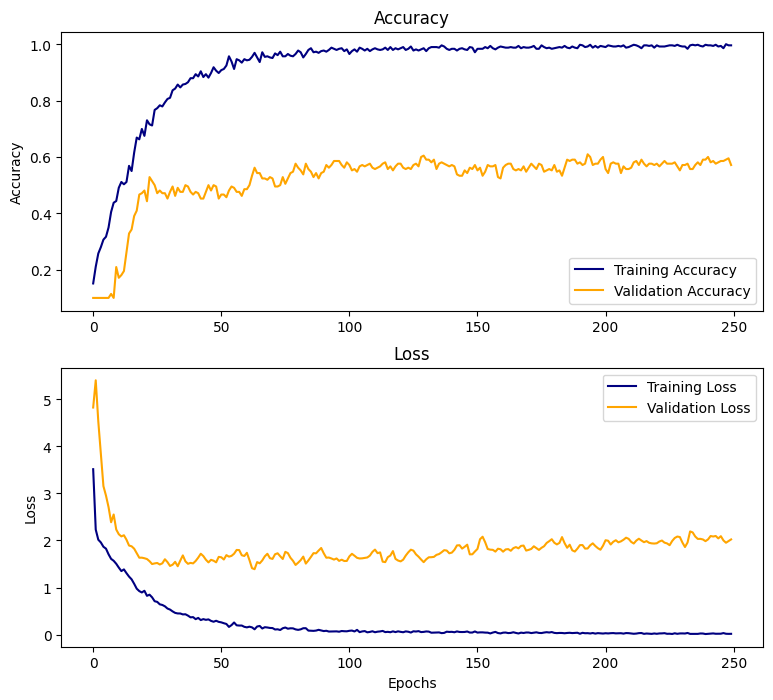

In [ ]:
import time

# Train the model
start_time = time.time()
hist_cnn_mel = model_cnn_mel.fit(
    X_train_mel, y_train_mel,
    validation_data=(X_val_mel, y_val_mel),
    batch_size=64,
    epochs=250,
    verbose=1
)
end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds")

# Evaluate the model on the test set
loss_cnn_mel, acc_cnn_mel = model_cnn_mel.evaluate(X_test_mel, y_test_mel)
print(f"\nCNN Mel Spectrogram Test Loss: {loss_cnn_mel}")
print(f"CNN Mel Spectrogram Test Accuracy: {acc_cnn_mel}")

# Plot the training history
plot_history(hist_cnn_mel)

In [ ]:
print(f"DNN Test Accuracy: {acc_dnn:.4f}")
print(f"CNN (Without Regularization) Test Accuracy: {acc_cnn1:.4f}")
print(f"CNN (With Regularization) Test Accuracy: {acc_cnn2:.4f}")
print(f"CNN (With Regularization and Data Augmentation) Test Accuracy: {acc_cnn3:.4f}")
print(f"Deeper Custom CNN Test Accuracy: {acc_cnn_deeper:.4f}")
print(f"LeNet-like CNN Test Accuracy: {acc_lenet_like:.4f}")
print(f"CNN Mel Spectrogram Test Accuracy: {acc_cnn_mel:.4f}")

DNN Test Accuracy: 0.5967
CNN (Without Regularization) Test Accuracy: 0.4733
CNN (With Regularization) Test Accuracy: 0.5367
CNN (With Regularization and Data Augmentation) Test Accuracy: 0.5133
Deeper Custom CNN Test Accuracy: 0.4933
LeNet-like CNN Test Accuracy: 0.5033
CNN Mel Spectrogram Test Accuracy: 0.5900


**Innovation Section:**

Although , we did see improvements in accuracy , however the team wasn't satisfied with the trivial improvement , hence we decided to further tweak the preprocessing and run a CNN with similar architecture.

Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 1. Instantiate MinMaxScaler
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

# 3. Reshape X_scaled to add two new dimensions for channels
# Original X shape: (1000, 40)
# Desired CNN input shape for 1D convolution: (num_samples, num_features, 1, 1)
X_scaled_cnn = X_scaled[..., np.newaxis, np.newaxis]

# 4. Split the reshaped X_scaled and y into training, validation, and test sets
X_train_val_scaled, X_test_scaled, y_train_val_scaled, y_test_scaled = train_test_split(
    X_scaled_cnn, y, test_size=0.3, random_state=42, stratify=y)

# Second split: From the train+val set, 30% for validation (which is 0.3 * 0.7 = 21% of total)
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(
    X_train_val_scaled, y_train_val_scaled, test_size=0.3, random_state=42, stratify=y_train_val_scaled)

# Print the shapes of the resulting sets
print(f"Shape of X_scaled_cnn: {X_scaled_cnn.shape}")
print(f"X training data shape (scaled): {X_train_scaled.shape}, y training data shape (scaled): {y_train_scaled.shape}")
print(f"X validation data shape (scaled): {X_val_scaled.shape}, y validation data shape (scaled): {y_val_scaled.shape}")
print(f"X test data shape (scaled): {X_test_scaled.shape}, y test data shape (scaled): {y_test_scaled.shape}")

Shape of X_scaled_cnn: (1000, 40, 1, 1)
X training data shape (scaled): (490, 40, 1, 1), y training data shape (scaled): (490,)
X validation data shape (scaled): (210, 40, 1, 1), y validation data shape (scaled): (210,)
X test data shape (scaled): (300, 40, 1, 1), y test data shape (scaled): (300,)


Rather simple architecture with just 2 convolution blocks

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Instantiate sequential model
model_cnn_scaled_original = Sequential()

# Add an Input layer to explicitly define the input shape
model_cnn_scaled_original.add(Input(shape=X_train_scaled.shape[1:]))

# First Conv2D layer
model_cnn_scaled_original.add(Conv2D(32, (3, 1), activation='relu', padding='same'))
model_cnn_scaled_original.add(BatchNormalization())
model_cnn_scaled_original.add(MaxPooling2D((2, 1), padding='same'))
model_cnn_scaled_original.add(Dropout(0.2))

# Second Conv2D layer.
model_cnn_scaled_original.add(Conv2D(64, (3, 1), activation='relu', padding='same'))
model_cnn_scaled_original.add(BatchNormalization())
model_cnn_scaled_original.add(MaxPooling2D((2, 1), padding='same'))
model_cnn_scaled_original.add(Dropout(0.1))

# Add a Flatten layer to convert the 2D output to 1D.
model_cnn_scaled_original.add(Flatten())
model_cnn_scaled_original.add(Dense(128, activation='relu'))
model_cnn_scaled_original.add(Dropout(0.5))

model_cnn_scaled_original.add(Dense(10, activation='softmax'))

# Compile the model
model_cnn_scaled_original.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

#  model summary
model_cnn_scaled_original.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 40, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,058 (351.79 KB)

 Trainable params: 89,866 (351.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - acc: 0.1201 - loss: 3.7701 - val_acc: 0.1000 - val_loss: 2.3041
Epoch 2/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.0994 - loss: 3.5498 - val_acc: 0.1238 - val_loss: 2.3036
Epoch 3/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1669 - loss: 3.1670 - val_acc: 0.1048 - val_loss: 2.3029
Epoch 4/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.1522 - loss: 3.1094 - val_acc: 0.1000 - val_loss: 2.3035
Epoch 5/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1598 - loss: 3.0505 - val_acc: 0.1000 - val_loss: 2.3043
Epoch 6/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1568 - loss: 2.9895 - val_acc: 0.1000 - val_loss: 2.3049
Epoch 7/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1947 - loss: 2.7988 - val_acc: 0.1000 - val_loss: 2.3055
Epoch 8/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1790 - loss: 2.5694 - val_acc: 0.1000 - val_loss: 2.3064
Epoch 9/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1967 - loss: 

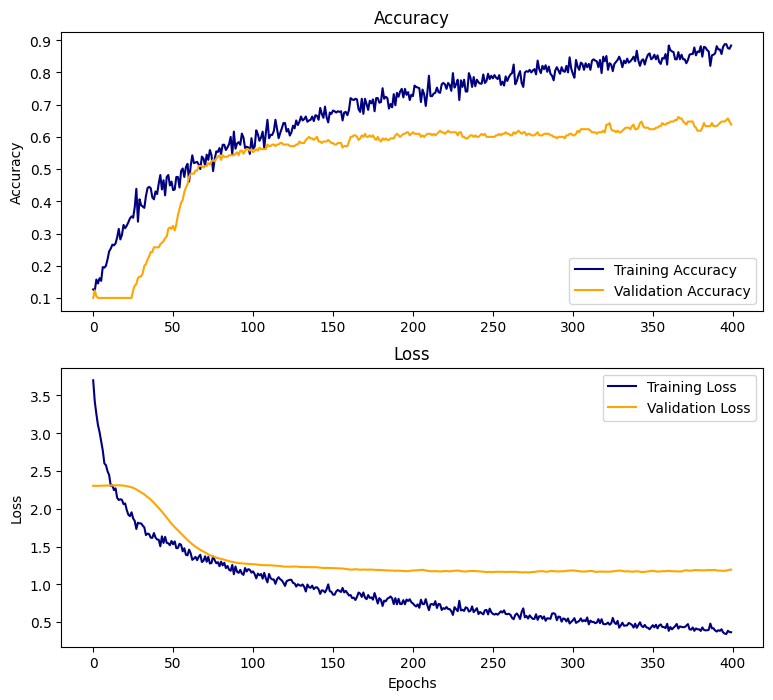

In [ ]:
import time

# Train the model
start_time = time.time()
hist_cnn_scaled_original = model_cnn_scaled_original.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    batch_size=64,
    epochs=400,
    verbose=1
)
end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds")

# Evaluate the model on the test set
loss_cnn_scaled_original, acc_cnn_scaled_original = model_cnn_scaled_original.evaluate(X_test_scaled, y_test_scaled)
print(f"\nCNN Scaled Original Test Loss: {loss_cnn_scaled_original}")
print(f"CNN Scaled Original Test Accuracy: {acc_cnn_scaled_original}")

# Plot the training history
plot_history(hist_cnn_scaled_original)

So we did manage to increase the accuracy to 67%.This  could be due to enhanced preprocessing of the second algorithm which retains the structure and order of the MFCC coefficients instead of randomly picking and scaling them.

Final Attempt : Using the same preprocessing as before but changing the activation function-weight initialisation combination to ReLU+HeUniform.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import HeUniform

# Instantiate sequential model
model_cnn_scaled_original = Sequential()

# Add an Input layer to explicitly define the input shape
model_cnn_scaled_original.add(Input(shape=X_train_scaled.shape[1:]))

# First Conv2D layer
model_cnn_scaled_original.add(Conv2D(32, (3, 1), activation='relu',kernel_initializer=HeUniform(), padding='same'))
model_cnn_scaled_original.add(BatchNormalization())
model_cnn_scaled_original.add(MaxPooling2D((2, 1), padding='same'))
model_cnn_scaled_original.add(Dropout(0.2))

# Second Conv2D layer.
model_cnn_scaled_original.add(Conv2D(64, (3, 1), activation='relu',kernel_initializer=HeUniform(), padding='same'))
model_cnn_scaled_original.add(BatchNormalization())
model_cnn_scaled_original.add(MaxPooling2D((2, 1), padding='same'))
model_cnn_scaled_original.add(Dropout(0.1))

# Add a Flatten layer to convert the 2D output to 1D.
model_cnn_scaled_original.add(Flatten())
model_cnn_scaled_original.add(Dense(128, activation='relu',kernel_initializer=HeUniform()))
model_cnn_scaled_original.add(Dropout(0.5))

model_cnn_scaled_original.add(Dense(10, activation='softmax'))

# Compile the model
model_cnn_scaled_original.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

#  model summary
model_cnn_scaled_original.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 40, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 40, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,058 (351.79 KB)

 Trainable params: 89,866 (351.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.0993 - loss: 4.0550 - val_acc: 0.0952 - val_loss: 2.4485
Epoch 2/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1269 - loss: 3.9095 - val_acc: 0.1333 - val_loss: 2.3749
Epoch 3/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1189 - loss: 3.5849 - val_acc: 0.1714 - val_loss: 2.3335
Epoch 4/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1429 - loss: 3.4133 - val_acc: 0.1524 - val_loss: 2.3094
Epoch 5/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1546 - loss: 3.3123 - val_acc: 0.1476 - val_loss: 2.2901
Epoch 6/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.1524 - loss: 3.0748 - val_acc: 0.1524 - val_loss: 2.2761
Epoch 7/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.1817 - loss: 2.9290 - val_acc: 0.1524 - val_loss: 2.2635
Epoch 8/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1651 - loss: 3.0276 - val_acc: 0.1571 - val_loss: 2.2497
Epoch 9/800
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1939 - loss: 

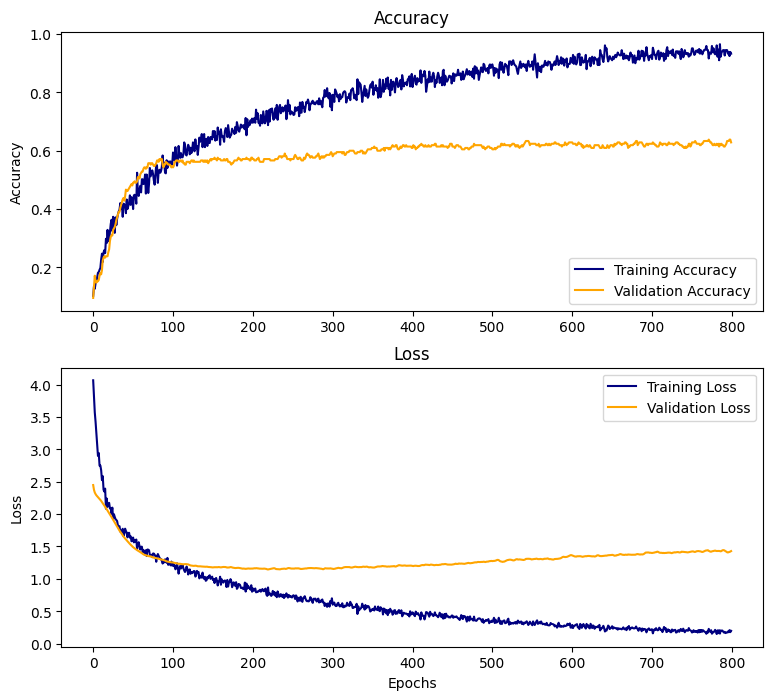

In [ ]:
import time

# Train the model
start_time = time.time()
hist_cnn_scaled_original = model_cnn_scaled_original.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    batch_size=64,
    epochs=800,
    verbose=1
)
end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds")

# Evaluate the model on the test set
loss_cnn_scaled_original, acc_cnn_scaled_original = model_cnn_scaled_original.evaluate(X_test_scaled, y_test_scaled)
print(f"\nCNN Scaled Original Test Loss: {loss_cnn_scaled_original}")
print(f"CNN Scaled Original Test Accuracy: {acc_cnn_scaled_original}")

# Plot the training history
plot_history(hist_cnn_scaled_original)